### Imports

In [26]:
import os
from os import listdir
from os.path import isfile, join

from PIL import Image

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
#import tensorflow as tf


### Image folder

In [12]:
image_dir = os.environ['IMAGES_FOLDER']
print(image_dir)

/Users/svinchon/code/NMenacho/To-infinity-and-beyond/data/images_cropped_sample


### Image folder to X,y

In [31]:
image_files = []
for f in listdir(image_dir):
    if isfile(os.path.join(image_dir, f)):
        if f.endswith(".jpg"):
            image_files.append(f)
        else:
            print("not jpg ignored")

X_list = []
y_list = []

for image_file in image_files:
    image_info = image_file.replace('.jpg', '').split("_")
    if len(image_info) > 4:
        cat = image_info[3]
        image_data = np.array(Image.open(os.path.join(image_dir,image_file)))
        X_list.append(image_data)
        y_list.append(cat)
    # else:
    #     os.remove(os.path.join(image_dir,image_file))

X_data = np.array(X_list)
print(X_data.shape)
y_data = np.array(y_list)
print(y_data.shape)

(2492, 128, 128, 3)
(2492,)


### View one image

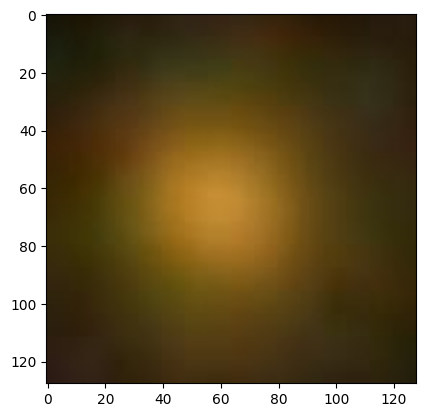

In [32]:
plt.imshow(X_data[3]) #/ use this tomorrow

### Check percentages

In [40]:
#y.value_counts()/len(y)

1    0.691241
0    0.308759
Name: count, dtype: float64

### Adjust y

In [33]:
import pandas as pd
y_data_cat = pd.Series(y_data).map({'STAR':0, 'GALAXY':1})
y_data_cat


0       0
1       1
2       1
3       1
4       1
       ..
2487    1
2488    0
2489    0
2490    0
2491    0
Length: 2492, dtype: int64

### Train/test split

In [34]:
X = X_data
y = y_data_cat

y_cat = to_categorical(y, num_classes=2)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_cat,
    test_size=0.2,
    random_state=42
)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1993, 128, 128, 3), (499, 128, 128, 3), (1993, 2), (499, 2))

### Model

In [37]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(2, activation='softmax')
])

/Users/svinchon/.pyenv/versions/3.10.6/envs/to_infinity_and_beyond/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model summary

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       576,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,424 (2.27 MB)

 Trainable params: 595,424 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

### Model compilation

In [39]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','recall','precision','mae','mse']
)

### Model training

In [40]:
es = EarlyStopping(patience=5)

history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=100,
    validation_split=0.2,
    callbacks=[es]
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7765 - loss: 5.9695 - mae: 0.2659 - mse: 0.2003 - precision: 0.7765 - recall: 0.7765 - val_accuracy: 0.9123 - val_loss: 0.2739 - val_mae: 0.1387 - val_mse: 0.0687 - val_precision: 0.9123 - val_recall: 0.9123
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9109 - loss: 0.3839 - mae: 0.1820 - mse: 0.0826 - precision: 0.9109 - recall: 0.9109 - val_accuracy: 0.9123 - val_loss: 0.3619 - val_mae: 0.1471 - val_mse: 0.0647 - val_precision: 0.9123 - val_recall: 0.9123
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9050 - loss: 0.3279 - mae: 0.1810 - mse: 0.0856 - precision: 0.9050 - recall: 0.9050 - val_accuracy: 0.9323 - val_loss: 0.7523 - val_mae: 0.1268 - val_mse: 0.0628 - val_precision: 0.9323 - val_recall: 0.9323
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9201 - loss: 0.2759 - mae: 0.1353 - mse: 0.0657 - precision: 0.9201 - recall: 0.9201 - val_accuracy: 0.9

### Model evaluation

In [41]:
model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9339 - loss: 0.2045 - mae: 0.1287 - mse: 0.0530 - precision: 0.9339 - recall: 0.9339


[0.19500991702079773,
 0.945891797542572,
 0.945891797542572,
 0.945891797542572,
 0.12644706666469574,
 0.05031091347336769]